# Football Match Probability Prediction (Kaggle)

This exercise notebook is based on the Kaggle competition [Football Match Probability Prediction](https://www.kaggle.com/competitions/football-match-probability-prediction/overview).

This is an ongoing machine learning exercise, using XGBoost in a multi-class classification problem.

Objective: to obtain the probabilities of each outcome of football matches (home, away or draw) with the lowest possible log loss.

## Imports and config

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.utils.class_weight import compute_class_weight



pd.set_option('display.max_columns', None)

SEED = 71

## Load train data

The data is available on the Kaggle competition page: [link](https://www.kaggle.com/competitions/football-match-probability-prediction/data).

In [ ]:
df = pd.read_csv('data/football-match-probability-prediction/train.csv')
# test = pd.read_csv('data/football-match-probability-prediction/test.csv')

# target = pd.read_csv('data/football-match-probability-prediction/train_target_and_scores.csv')

/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_22862/3310068306.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/football-match-probability-prediction/train.csv')


In [ ]:
df.shape

(110938, 190)

In [ ]:
df.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [ ]:
df.info(verbose=True)    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72711 entries, 0 to 72710
Data columns (total 189 columns):
 #    Column                                Dtype  
---   ------                                -----  
 0    id                                    int64  
 1    home_team_name                        object 
 2    away_team_name                        object 
 3    match_date                            object 
 4    league_name                           object 
 5    league_id                             int64  
 6    is_cup                                bool   
 7    home_team_coach_id                    float64
 8    away_team_coach_id                    float64
 9    home_team_history_match_date_1        object 
 10   home_team_history_match_date_2        object 
 11   home_team_history_match_date_3        object 
 12   home_team_history_match_date_4        object 
 13   home_team_history_match_date_5        object 
 14   home_team_history_match_date_6        object 
 15   

## Preliminary Data Cleansing

In [5]:
def data_cleansing(df_base):
    df = df_base.copy()
    for col in [col for col in df.columns if 'date' in col]:
        # print(col)
        df[col] = pd.to_datetime(df[col])
    return df

In [ ]:
df[[col for col in df.columns if 'date' in col]].head()

,match_date,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10
0,2019-12-01 00:45:00,2019-11-26 00:10:00,2019-11-10 18:30:00,2019-11-03 18:30:00,2019-10-29 22:10:00,2019-10-19 20:45:00,2019-10-04 22:00:00,2019-09-28 23:00:00,2019-09-22 14:00:00,2019-09-15 18:30:00,2019-09-01 16:15:00,2019-11-23 20:00:00,2019-11-15 00:10:00,2019-11-10 14:00:00,2019-11-02 23:00:00,2019-10-30 00:20:00,2019-10-23 00:30:00,2019-10-18 22:00:00,2019-10-11 23:30:00,2019-10-06 20:45:00,2019-10-02 00:30:00
1,2019-12-01 01:00:00,2019-11-27 21:00:00,2019-11-24 01:00:00,2019-11-10 01:00:00,2019-11-02 21:30:00,2019-10-27 01:00:00,2019-10-24 01:00:00,2019-10-21 00:00:00,2019-10-18 01:00:00,2019-10-06 01:00:00,2019-09-29 21:00:00,2019-11-27 21:00:00,2019-11-23 23:00:00,2019-11-09 22:00:00,2019-11-02 21:00:00,2019-10-28 00:00:00,2019-10-21 00:00:00,2019-10-16 21:00:00,2019-09-29 01:00:00,2019-09-20 21:30:00,2019-09-15 01:00:00
2,2019-12-01 01:00:00,2019-11-28 01:15:00,2019-11-21 01:30:00,2019-11-03 21:30:00,2019-10-27 01:00:00,2019-10-20 22:00:00,2019-10-17 01:00:00,2019-10-05 21:00:00,2019-09-29 01:00:00,2019-09-22 22:00:00,2019-09-19 01:00:00,2019-11-21 01:30:00,2019-11-10 22:00:00,2019-10-26 21:00:00,2019-10-20 23:00:00,2019-10-16 21:30:00,2019-10-12 21:00:00,2019-10-05 21:00:00,2019-09-28 22:00:00,2019-09-22 22:00:00,2019-09-18 21:30:00
3,2019-12-01 01:00:00,2019-11-28 01:00:00,2019-11-23 03:10:00,2019-11-10 03:00:00,2019-11-04 02:00:00,2019-11-01 03:00:00,2019-10-27 01:00:00,2019-10-20 17:00:00,2019-10-05 22:00:00,2019-09-28 00:00:00,2019-09-25 02:00:00,2019-11-28 01:00:00,2019-11-23 23:00:00,2019-11-09 01:00:00,2019-11-04 02:00:00,2019-11-01 01:00:00,2019-10-26 00:00:00,2019-10-19 22:00:00,2019-10-05 02:00:00,2019-10-02 02:00:00,2019-09-26 02:06:00
4,2019-12-01 01:00:00,2019-11-27 18:00:00,2019-11-24 01:00:00,2019-11-10 02:00:00,2019-11-03 01:00:00,2019-10-27 20:30:00,2019-10-24 00:00:00,2019-10-20 18:00:00,2019-10-06 17:00:00,2019-10-02 21:30:00,2019-09-29 01:00:00,2019-11-27 19:00:00,2019-11-24 21:00:00,2019-11-10 19:30:00,2019-11-02 19:00:00,2019-10-26 21:00:00,2019-10-23 19:00:00,2019-10-20 17:30:00,2019-10-05 19:00:00,2019-10-02 19:00:00,2019-09-29 18:00:00


## Exploratory Data Analysis

- unit of observation: match
- descriptive: match date, home and away team, league, cup flag, coach
- historical: dates, home or away, team and opponent's goals and rating, team's coach and league

obs: rating is calculated by Octosport, "meant to give information on the team's relative strength for a given match" ([source](https://www.kaggle.com/competitions/football-match-probability-prediction/data)).

### Missing data

- many columns with NaN values
- columns with no possibility for filling:
    - goal columns (great impact on the match result)
    - rating columns (the rating calculation is unknown)
- when the missing data of those columns is droped, we have some missing data left, mainly coach_id and is_cup

In [ ]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72711 entries, 0 to 72710
Data columns (total 189 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    id                                    72711 non-null  int64  
 1    home_team_name                        72711 non-null  object 
 2    away_team_name                        72711 non-null  object 
 3    match_date                            72711 non-null  object 
 4    league_name                           72711 non-null  object 
 5    league_id                             72711 non-null  int64  
 6    is_cup                                72711 non-null  bool   
 7    home_team_coach_id                    54135 non-null  float64
 8    away_team_coach_id                    54200 non-null  float64
 9    home_team_history_match_date_1        72213 non-null  object 
 10   home_team_history_match_date_2        71629 non-null  object 
 11   

In [ ]:
# sample with historical columns
df[[column for column in df.columns if column.endswith("1")]].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   home_team_history_match_date_1       109779 non-null  object 
 1   home_team_history_is_play_home_1     109779 non-null  float64
 2   home_team_history_is_cup_1           109725 non-null  float64
 3   home_team_history_goal_1             109779 non-null  float64
 4   home_team_history_opponent_goal_1    109779 non-null  float64
 5   home_team_history_rating_1           109767 non-null  float64
 6   home_team_history_opponent_rating_1  109767 non-null  float64
 7   home_team_history_coach_1            89415 non-null   float64
 8   home_team_history_league_id_1        109779 non-null  float64
 9   away_team_history_match_date_1       109712 non-null  object 
 10  away_team_history_is_play_home_1     109712 non-null  float64
 11  away_team_his

In [ ]:
goal_columns = [column for column in df.columns if 'goal' in column]
rating_colums = [column for column in df.columns if 'rating' in column]

print(len(df)) # full dataset
print(len(df.dropna())) # dataset without nan values
print(len(df.dropna(subset=goal_columns, axis=0)))
print(len(df.dropna(subset=rating_colums, axis=0)))

print(len(df.dropna(subset= goal_columns + rating_colums, axis=0)))

110938
96
91653
91483
91483


In [ ]:
print('Total missing data:', df.dropna(subset= goal_columns + rating_colums, axis=0).isnull().sum().sum())
print('Total columns:', len(df.columns))
nan_cols = [i for i in df.columns if df[i].isnull().any()]
print('Columns with missing data:', len(nan_cols))
nan_cols_drop = [i for i in df.dropna(subset= goal_columns + rating_colums, axis=0).columns if df.dropna(subset= goal_columns + rating_colums, axis=0)[i].isnull().any()]
print('Columns with missing data after dropna goals and rating:', len(nan_cols_drop))

# df.dropna(subset= goal_columns + rating_colums, axis=0).info(verbose=True,show_counts=True)

Total missing data: 250148
Total columns: 190
Columns with missing data: 186
Columns with missing data after dropna goals and rating: 46


In [ ]:
nan_cols

['home_team_name',
 'away_team_name',
 'league_name',
 'is_cup',
 'home_team_coach_id',
 'away_team_coach_id',
 'home_team_history_is_cup_1',
 'home_team_history_is_cup_2',
 'home_team_history_is_cup_3',
 'home_team_history_is_cup_4',
 'home_team_history_is_cup_5',
 'home_team_history_is_cup_6',
 'home_team_history_is_cup_7',
 'home_team_history_is_cup_8',
 'home_team_history_is_cup_9',
 'home_team_history_is_cup_10',
 'home_team_history_coach_1',
 'home_team_history_coach_2',
 'home_team_history_coach_3',
 'home_team_history_coach_4',
 'home_team_history_coach_5',
 'home_team_history_coach_6',
 'home_team_history_coach_7',
 'home_team_history_coach_8',
 'home_team_history_coach_9',
 'home_team_history_coach_10',
 'away_team_history_is_cup_1',
 'away_team_history_is_cup_2',
 'away_team_history_is_cup_3',
 'away_team_history_is_cup_4',
 'away_team_history_is_cup_5',
 'away_team_history_is_cup_6',
 'away_team_history_is_cup_7',
 'away_team_history_is_cup_8',
 'away_team_history_is_cup_9'

In [ ]:
df[['league_id', 'is_cup']].drop_duplicates()['league_id'].value_counts().head(10)

league_id
660     2
1101    2
1107    2
1313    2
205     1
1244    1
815     1
1809    1
1811    1
1829    1
Name: count, dtype: int64

#### League names

In [ ]:
# agrupado_id = df.groupby('league_id').league_name.nunique().reset_index(name='count')
# agrupado_name = df.groupby('league_name').league_id.nunique().reset_index(name='count')

# # Verificar se há combinações nome-ID duplicadas
# print('Ids with duplicated name', len(agrupado_id[agrupado_id['count'] > 1]))
# print('Names with duplicated ids', len(agrupado_name[agrupado_name['count'] > 1]))

# df.loc[(df.league_id.isin(agrupado_id[agrupado_id['count'] > 1]['league_id']))
#     | (df.league_name.isin(agrupado_name[agrupado_name['count'] > 1]['league_name']))
#     ][['league_id', 'league_name']].drop_duplicates()

#### Cups: contradictory and missing data

- 3 leagues with different flag is_cup and 1 with null value is_cup
- very few cases, a quick research helped define the correct values

In [ ]:
agrupado_id = df.groupby(['league_id', 'league_name']).is_cup.nunique().reset_index(name='count')
print('Ids with duplicated is_cup', len(agrupado_id[agrupado_id['count'] > 1]))
agrupado_id[agrupado_id['count'] > 1]

Ids with duplicated is_cup 3


,league_id,league_name,count
215,660,Serie D,2
336,1107,CAF Champions League,2
477,1313,Paulista A1,2


In [ ]:
df.loc[df['is_cup'].isna()]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [ ]:
df.loc[df['league_id'] == 1101].head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [ ]:
teste = df.dropna(subset= goal_columns + rating_colums, axis=0)
teste[teste['home_team_history_is_cup_4'].isna()][['home_team_history_league_id_4', 'home_team_history_is_cup_4']]

,home_team_history_league_id_4,home_team_history_is_cup_4
4233,1589.0,NaN
7213,1684.0,NaN
7334,660.0,NaN
7410,1684.0,NaN
7584,1684.0,NaN
8018,1684.0,NaN
8037,1684.0,NaN
8054,660.0,NaN
8515,1684.0,NaN
9643,1312.0,NaN


In [ ]:
correct_is_cup = {
    660: False,
    1107: True,
    1313: True,
    1101: False,
}

# df['is_cup'] = df['league_id'].map(correct_is_cup)
# df['is_cup'] = df['league_id'].replace(correct_is_cup)

df['is_cup_correct'] = df['league_id'].map(correct_is_cup)
df['is_cup_correct'] = df['is_cup_correct'].fillna(df['is_cup'])


dict_is_cup = df[['league_id', 'is_cup_correct']].set_index('league_id')['is_cup_correct'].to_dict()
df['is_cup'] = df['is_cup_correct']
df.drop(columns='is_cup_correct', inplace=True)

# function for filling nan values on history columns
def fillna_is_cup(df, dict_is_cup, league_id_column, is_cup_column):
    # df[f'{is_cup_column}_correct'] = df[is_cup_column].fillna(df[league_id_column].map(dict_is_cup))
    df[f'{is_cup_column}_correct'] = df[league_id_column].map(dict_is_cup)
    df[f'{is_cup_column}_correct'] = df[f'{is_cup_column}_correct'].fillna(df[is_cup_column])
    df[is_cup_column] = df[f'{is_cup_column}_correct']
    df.drop(columns=f'{is_cup_column}_correct', inplace=True)

    return df

for i in range(1,11):
    fillna_is_cup(df, dict_is_cup,f'home_team_history_league_id_{i}', f'home_team_history_is_cup_{i}')
    fillna_is_cup(df, dict_is_cup,f'away_team_history_league_id_{i}', f'away_team_history_is_cup_{i}')

/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_22862/1532977014.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_cup_correct'] = df['is_cup_correct'].fillna(df['is_cup'])


In [ ]:
teste = df.dropna(subset= goal_columns + rating_colums, axis=0)
teste[teste['home_team_history_is_cup_4'].isna()][['home_team_history_league_id_4', 'home_team_history_is_cup_4']]

,home_team_history_league_id_4,home_team_history_is_cup_4
11463,1698.0,NaN
12049,1698.0,NaN
12539,1698.0,NaN
12950,1399.0,NaN
20659,1355.0,NaN
66301,1117.0,NaN
89954,1369.0,NaN


In [ ]:
agrupado_id = df.groupby(['league_id']).is_cup.nunique().reset_index(name='count')
print('Ids with duplicated is_cup', len(agrupado_id[agrupado_id['count'] > 1]))
agrupado_id[agrupado_id['count'] > 1]

Ids with duplicated is_cup 0


,league_id,count


In [ ]:
print('Total missing data:', df.dropna(subset= goal_columns + rating_colums, axis=0).isnull().sum().sum())
print('Total columns:', len(df.columns))
nan_cols = [i for i in df.columns if df[i].isnull().any()]
print('Columns with missing data:', len(nan_cols))
nan_cols_drop = [i for i in df.dropna(subset= goal_columns + rating_colums, axis=0).columns if df.dropna(subset= goal_columns + rating_colums, axis=0)[i].isnull().any()]
print('Columns with missing data after dropna goals and rating:', len(nan_cols_drop))
# there are still league ids with nan values for is_cup

Total missing data: 247416
Total columns: 190
Columns with missing data: 185
Columns with missing data after dropna goals and rating: 45


In [ ]:
ids_no_info = []
for i in range(1,11):
    ids_no_info.append(df.loc[df[f'home_team_history_is_cup_{i}'].isna()][f'home_team_history_league_id_{i}'].unique()[0])
    ids_no_info.append(df.loc[df[f'away_team_history_is_cup_{i}'].isna()][f'away_team_history_league_id_{i}'].unique()[0])
ids_no_info = set(ids_no_info)
print('Ids with nan values for is_cup:', ids_no_info)

# new dictionary for is_cup values
dict_is_cup_2 = {}

# for id in ids_no_info:
#     for col_id, col_is_cup in zip(df.filter(like='league_id').columns, df.filter(like='is_cup').columns):
#         if id in df[col_id].values:
#             value_is_cup = df.loc[df[col_id] == id, col_is_cup].values[0]
#             dict_is_cup_2[id] = value_is_cup

# dict_is_cup_2

Ids with nan values for is_cup: {nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan}


In [ ]:
# we still have 2 cups with no info
# we will fill up the rest with the majority value

is_cup_count = {}
for valor in dict_is_cup.values():
    is_cup_count[valor] = is_cup_count.get(valor, 0) + 1
print(is_cup_count)

{False: 642, True: 220}


In [ ]:
dict_is_cup_2 = {1698.0: 0, 1715.0: 0, 1117.0: 1.0}

for i in range(1,11):
    fillna_is_cup(df, dict_is_cup_2,f'home_team_history_league_id_{i}', f'home_team_history_is_cup_{i}')
    fillna_is_cup(df, dict_is_cup_2,f'away_team_history_league_id_{i}', f'away_team_history_is_cup_{i}')

In [ ]:
teste = df.dropna(subset= goal_columns + rating_colums, axis=0)
teste[teste['home_team_history_is_cup_4'].isna()][['home_team_history_league_id_4', 'home_team_history_is_cup_4']]

,home_team_history_league_id_4,home_team_history_is_cup_4
12950,1399.0,NaN
20659,1355.0,NaN
89954,1369.0,NaN


In [ ]:
dict_is_cup_2[1399]

KeyError: 1399

In [ ]:
print('Total missing data:', df.dropna(subset= goal_columns + rating_colums, axis=0).isnull().sum().sum())
print('Total columns:', len(df.columns))
nan_cols = [i for i in df.columns if df[i].isna().any()]
print('Columns with missing data:', len(nan_cols))
nan_cols_drop = [i for i in df.dropna(subset= goal_columns + rating_colums, axis=0).columns if df.dropna(subset= goal_columns + rating_colums, axis=0)[i].isna().any()]
print('Columns with missing data after dropna goals and rating:', len(nan_cols_drop))


Total missing data: 247416
Total columns: 190
Columns with missing data: 185
Columns with missing data after dropna goals and rating: 45


In [ ]:
df.dropna(subset= goal_columns + rating_colums, axis=0).columns

Index(['id', 'target', 'home_team_name', 'away_team_name', 'match_date',
       'league_name', 'league_id', 'is_cup', 'home_team_coach_id',
       'away_team_coach_id',
       ...
       'away_team_history_league_id_1', 'away_team_history_league_id_2',
       'away_team_history_league_id_3', 'away_team_history_league_id_4',
       'away_team_history_league_id_5', 'away_team_history_league_id_6',
       'away_team_history_league_id_7', 'away_team_history_league_id_8',
       'away_team_history_league_id_9', 'away_team_history_league_id_10'],
      dtype='object', length=190)

In [ ]:
df.dropna(subset= goal_columns + rating_colums, axis=0)['home_team_history_league_id_4'].info()

<class 'pandas.core.series.Series'>
Index: 91483 entries, 0 to 110937
Series name: home_team_history_league_id_4
Non-Null Count  Dtype  
--------------  -----  
91483 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [ ]:
df.dropna(subset= goal_columns + rating_colums, axis=0)['home_team_history_is_cup_4'].info()

<class 'pandas.core.series.Series'>
Index: 91483 entries, 0 to 110937
Series name: home_team_history_is_cup_4
Non-Null Count  Dtype 
--------------  ----- 
91476 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB


In [ ]:
teste = df.dropna(subset= goal_columns + rating_colums, axis=0)
teste[teste['home_team_history_is_cup_4'].isna()]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [ ]:
nan_cols_drop

['home_team_name',
 'away_team_name',
 'league_name',
 'home_team_coach_id',
 'away_team_coach_id',
 'home_team_history_is_cup_1',
 'home_team_history_is_cup_2',
 'home_team_history_is_cup_3',
 'home_team_history_is_cup_4',
 'home_team_history_is_cup_5',
 'home_team_history_is_cup_6',
 'home_team_history_is_cup_7',
 'home_team_history_is_cup_8',
 'home_team_history_is_cup_9',
 'home_team_history_is_cup_10',
 'home_team_history_coach_1',
 'home_team_history_coach_2',
 'home_team_history_coach_3',
 'home_team_history_coach_4',
 'home_team_history_coach_5',
 'home_team_history_coach_6',
 'home_team_history_coach_7',
 'home_team_history_coach_8',
 'home_team_history_coach_9',
 'home_team_history_coach_10',
 'away_team_history_is_cup_1',
 'away_team_history_is_cup_2',
 'away_team_history_is_cup_3',
 'away_team_history_is_cup_4',
 'away_team_history_is_cup_5',
 'away_team_history_is_cup_6',
 'away_team_history_is_cup_7',
 'away_team_history_is_cup_8',
 'away_team_history_is_cup_9',
 'away_te

### Rating

In [ ]:
df[[column for column in df.columns if "rating" in column]].describe().T

,count,mean,std,min,25%,50%,75%,max
home_team_history_rating_1,109767.0,6.325486,2.670843,0.217600,4.616889,5.690300,7.290464,57.861050
home_team_history_rating_2,108472.0,6.651585,2.693074,0.255600,4.913283,6.046611,7.665168,49.969875
home_team_history_rating_3,107153.0,6.526625,2.730215,0.217600,4.776545,5.895133,7.526083,57.861050
home_team_history_rating_4,105821.0,6.597575,2.700185,0.255600,4.866850,5.980830,7.592956,45.849650
home_team_history_rating_5,104453.0,6.548819,2.696488,0.217600,4.815040,5.938521,7.534800,49.969875
home_team_history_rating_6,103029.0,6.582106,2.709772,0.471950,4.848234,5.964398,7.574117,55.699900
home_team_history_rating_7,101630.0,6.556376,2.704181,0.255600,4.837451,5.951981,7.530079,55.699900
home_team_history_rating_8,100209.0,6.559520,2.674349,0.255600,4.845200,5.960538,7.538590,55.699900
home_team_history_rating_9,98797.0,6.550602,2.668547,0.241800,4.845097,5.953668,7.528285,55.699900
home_team_history_rating_10,97372.0,6.544828,2.671623,0.241800,4.840749,5.948483,7.521593,53.630950


/Users/marianacarvalhoteixeira/opt/anaconda3/envs/envds/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='home_team_history_rating_1', ylabel='Percent'>

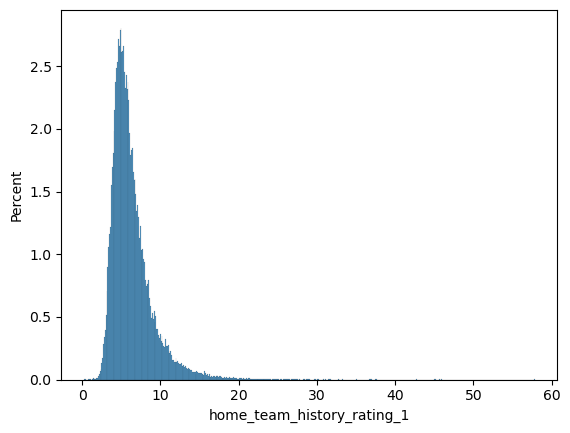

In [ ]:
sns.histplot(data=df, x='home_team_history_rating_1', stat='percent')

In [ ]:
df

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

<Axes: xlabel='home_team_history_is_play_home_1', ylabel='home_team_history_rating_1'>

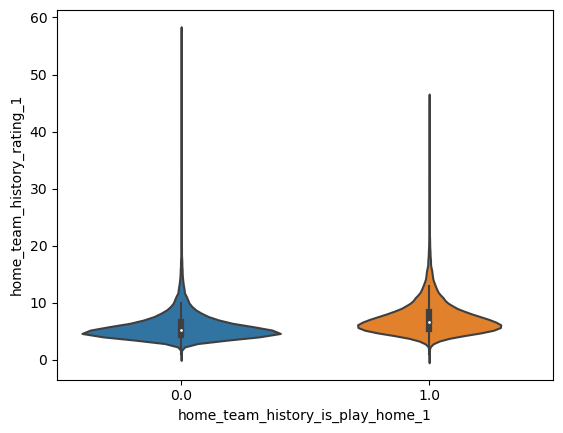

In [ ]:
sns.violinplot(data=df, y='home_team_history_rating_1', x='home_team_history_is_play_home_1', split=True)

### Target

## Feature Engineering

In [62]:
def feature_engineering(df_base):
    df = df_base.copy()
    for team in ['home_team_history', 'away_team_history']:
        for i in range(1, 11):
            # match result
            df[f'{team}_match_winner_{i}'] = (df[f'{team}_goal_{i}'] > df[f'{team}_opponent_goal_{i}']).astype(int)
            df[f'{team}_match_draw_{i}'] = (df[f'{team}_goal_{i}'] == df[f'{team}_opponent_goal_{i}']).astype(int)
            # goal margin
            df[f'{team}_margin_{i}'] = df[f'{team}_goal_{i}'] - df[f'{team}_opponent_goal_{i}']
            # favorite or underdog
            df[f'{team}_favorite_{i}'] = (df[f'{team}_rating_{i}'] > df[f'{team}_opponent_rating_{i}']).astype(int)
            # rating ratio
            df[f'{team}_rating_ratio_{i}'] = df[f'{team}_rating_{i}']/df[f'{team}_opponent_rating_{i}']
            df[f'{team}_rating_ratio_{i}'] = np.nan_to_num(df[f'{team}_rating_ratio_{i}'], nan=0.0, posinf=0.0, neginf=0.0)
            # rating per goals (the goal's "value")
            df[f'{team}_goals_per_rating_{i}'] = df[f'{team}_rating_{i}']/df[f'{team}_goal_{i}']
            df[f'{team}_goals_per_rating_{i}'] = np.nan_to_num(df[f'{team}_goals_per_rating_{i}'], nan=0.0, posinf=0.0, neginf=0.0)
            # weighted goals scored (goals times rating ratio)
            df[f'{team}_weighted_gscored_{i}'] = df[f'{team}_goal_{i}']*df[f'{team}_rating_ratio_{i}']
    
        # historic descriptive stats
        df[f'{team}_avg_goals'] = df[[col for col in df.columns if col.startswith(f'{team}_goal_')]].mean(axis=1)
        df[f'{team}_std_goals'] = df[[col for col in df.columns if col.startswith(f'{team}_goal_')]].std(axis=1)

        df[f'{team}_avg_margins'] = df[[col for col in df.columns if col.startswith(f'{team}_margin_')]].mean(axis=1)
        df[f'{team}_std_margins'] = df[[col for col in df.columns if col.startswith(f'{team}_margin_')]].std(axis=1)

        df[f'{team}_avg_favorite'] = df[[col for col in df.columns if col.startswith(f'{team}_favorite_')]].mean(axis=1)

        df[f'{team}_avg_rating'] = df[[col for col in df.columns if col.startswith(f'{team}_rating_')]].mean(axis=1)
        df[f'{team}_std_rating'] = df[[col for col in df.columns if col.startswith(f'{team}_rating_')]].std(axis=1)
        df[f'{team}_avg_opponent_rating'] = df[[col for col in df.columns if col.startswith(f'{team}_opponent_rating_')]].mean(axis=1)
        df[f'{team}_std_opponent_rating'] = df[[col for col in df.columns if col.startswith(f'{team}_opponent_rating_')]].std(axis=1)

        # comparative rating
        # df[f'{team}_avg_rating_ratio'] = df[f'{team}_rating']/df[f'{team}_avg_rating']
        # df[f'{team}_avg_rating_ratio'] = np.nan_to_num(df[f'{team}_avg_rating_ratio'], nan=0.0, posinf=0.0, neginf=0.0)
        # df[f'{team}_avg_opponent_rating_ratio'] = df[f'{team}_opponent_rating']/df[f'{team}_avg_opponent_rating']
        # df[f'{team}_avg_opponent_rating_ratio'] = np.nan_to_num(df[f'{team}_avg_opponent_rating_ratio_{i}'], nan=0.0, posinf=0.0, neginf=0.0)


    return df

In [ ]:
feature_engineering(df)

/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_22862/2943646636.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{team}_avg_goals_{i}'] = df[[col for col in df.columns if col.startswith(f'{team}_goal_')]].mean(axis=1)
/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_22862/2943646636.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{team}_std_goals_{i}'] = df[[col for col in df.columns if col.startswith(f'{team}_goal_')]].std(axis=1)
/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykerne

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [ ]:
df.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [ ]:
# sample with historical columns
df[[column for column in df.columns if column.endswith("1")]].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   home_team_history_match_date_1       109779 non-null  object 
 1   home_team_history_is_play_home_1     109779 non-null  float64
 2   home_team_history_is_cup_1           109773 non-null  object 
 3   home_team_history_goal_1             109779 non-null  float64
 4   home_team_history_opponent_goal_1    109779 non-null  float64
 5   home_team_history_rating_1           109767 non-null  float64
 6   home_team_history_opponent_rating_1  109767 non-null  float64
 7   home_team_history_coach_1            89415 non-null   float64
 8   home_team_history_league_id_1        109779 non-null  float64
 9   away_team_history_match_date_1       109712 non-null  object 
 10  away_team_history_is_play_home_1     109712 non-null  float64
 11  away_team_his

## Feature selection

## Model training

In [63]:
train = pd.read_csv('data/football-match-probability-prediction/train.csv')

train = data_cleansing(train)
train = feature_engineering(train)

/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_30241/1533945681.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/football-match-probability-prediction/train.csv')
/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_30241/3818430889.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{team}_favorite_{i}'] = (df[f'{team}_rating_{i}'] > df[f'{team}_opponent_rating_{i}']).astype(int)
/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_30241/3818430889.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

110938
72711
110938


/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_30241/3818430889.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{team}_margin_{i}'] = df[f'{team}_goal_{i}'] - df[f'{team}_opponent_goal_{i}']
/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_30241/3818430889.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{team}_favorite_{i}'] = (df[f'{team}_rating_{i}'] > df[f'{team}_opponent_rating_{i}']).astype(int)
/var/folders/f_/m75l_76x7wx779ps31w8sxj80000gn/T/ipykernel_30241/3818430889.py:13: Perfor

In [64]:
columns_to_drop = [
    'id',
    'home_team_name',
    'away_team_name',
    'match_date',
    'league_name',
    'league_id',
    'home_team_coach_id',
    'away_team_coach_id',
] + [col for col in train.columns if 'date' in col] + [col for col in train.columns if 'coach' in col] + [col for col in train.columns if 'league' in col]

In [ ]:
train.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [69]:
train['is_cup'] = train['is_cup'].astype(float)


X = train.dropna().copy()
X.drop(columns=columns_to_drop + ['target'], inplace=True)
X = X.apply(pd.to_numeric, errors='coerce')
y = train.dropna()['target']


# label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)

original_classes = label_encoder.classes_
numeric_values = label_encoder.transform(original_classes)
class_mapping = dict(zip(original_classes, numeric_values))

print("Class mapping:")
print(class_mapping)


# split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=SEED)


# class weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
sample_weights = np.array([class_weight_dict[label] for label in y_train])


clf = XGBClassifier(
    objective='multi:softprob',  # Multiclass classification with probabilities
    num_class=3,                 # Number of classes
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=SEED,
    sample_weight = sample_weights

)
clf.fit(X_train, y_train)


preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)


Class mapping:
{'away': 0, 'draw': 1, 'home': 2}


/Users/marianacarvalhoteixeira/opt/anaconda3/envs/envds/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:12:31] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_d6q0e1lomi/croot/xgboost-split_1713972719224/work/cpp_src/src/learner.cc:742: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [70]:
logloss = log_loss(y_true=y_test, y_pred=probas)
logloss

1.0209469948899959

In [52]:
probas

array([[0.42790666, 0.2966325 , 0.2754608 ],
       [0.28232405, 0.24793065, 0.46974534],
       [0.17838949, 0.27378744, 0.5478231 ],
       ...,
       [0.31176904, 0.30339292, 0.38483807],
       [0.45756796, 0.23761746, 0.30481455],
       [0.43730566, 0.28498963, 0.27770472]], dtype=float32)